In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [3]:
evds=evdsAPI('dsIC3fiGlu')


In [4]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4618,16-10-2023,27.7939
4619,17-10-2023,27.8865
4620,18-10-2023,27.9221
4621,19-10-2023,28.0163


In [5]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [6]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


In [7]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [8]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


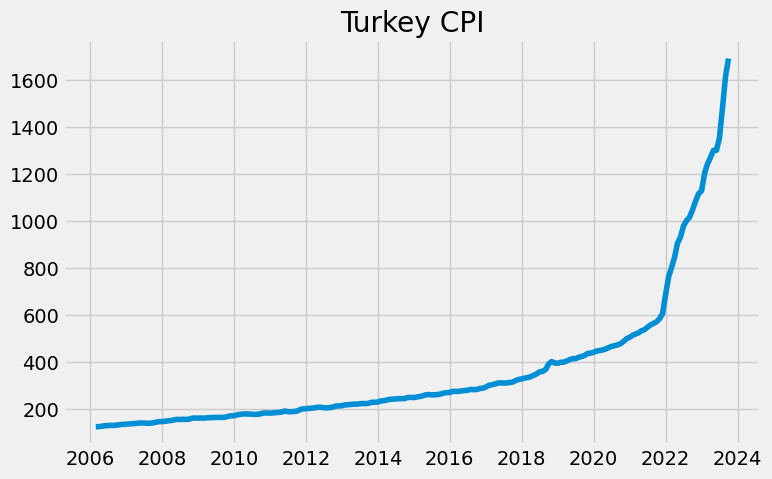

In [9]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [11]:
dates= pd.date_range('2006-02-01','2023-11-01' , freq='1M')           
df6=df6.set_index(dates)
df6


,USD/TL
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [12]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del money["Tarih"]
money['Tarih'] = pd.to_datetime(money['YEARWEEK'] + '-1', format='%Y-%W-%w')
money = money.groupby(money['Tarih'].dt.to_period('M'))['TP_PR_ARZ13'].mean()
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(df6.index)
money

,Para Arzi
2006-02-28,2.424295
2006-03-31,2.473023
2006-04-30,2.514337
2006-05-31,2.648480
2006-06-30,2.794302
...,...
2023-06-30,104.034758
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258


In [13]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4610,04-10-2023,89.83
4611,05-10-2023,88.28
4612,06-10-2023,87.86
4613,09-10-2023,91.37


In [14]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [15]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [16]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10


In [17]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870


In [18]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870


In [19]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00


In [20]:
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-06-30,12.84
2023-07-31,17.50
2023-08-31,23.50


In [21]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.2980


In [22]:
perakende=pd.read_excel("C:/Users/Bora/Downloads/perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-04-30,165.916139,169.886079,174.404111
2023-05-31,181.176925,179.726145,180.185729
2023-06-30,180.070938,186.141640,180.131292
2023-07-31,191.355951,193.831190,185.482059


In [23]:
motorin=pd.read_excel("C:/Users/Bora/Downloads/motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-10-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-05-31,18.920000
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000


In [24]:
sanayi=evds.get_data(["TP.SANAYREV4.Y1"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
sanayi=sanayi.set_index(pd.date_range(start="2006-02-01",end="2023-09-01",freq="1M"))
del sanayi["Tarih"]
sanayi.columns=["Sanayi"]
sanayi

,Sanayi
2006-02-28,55.819129
2006-03-31,65.933232
2006-04-30,62.501869
2006-05-31,66.499838
2006-06-30,67.519860
...,...
2023-04-30,129.873251
2023-05-31,149.379361
2023-06-30,137.891848
2023-07-31,145.483816


In [25]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-11-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-06-30,39.5920
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560


In [26]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-11-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30


In [27]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate="30-10-2023",frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-09-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-04-30,2.292927e+09
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09


In [28]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate="30-10-2023",frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-10-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-05-31,94.52
2023-06-30,87.07
2023-07-31,81.77
2023-08-31,84.81


In [29]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate="30-10-2023",frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-10-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-05-31,58.00
2023-06-30,51.60
2023-07-31,48.71
2023-08-31,52.42


In [356]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.head(211)
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,TÜFE
2011-04-30,-0.810542,2.440539,-1.218711,-0.176965,-3.796845,0.684613,2.978727,1.593625,2.284537,0.866270
2011-05-31,-0.399628,0.458932,-1.660706,1.110822,4.626047,0.570506,3.568114,-3.090570,-1.121135,2.420827
2011-06-30,0.415548,1.955789,2.055258,2.490629,4.308985,0.194110,3.122424,-1.878794,-3.463549,-1.430743
2011-07-31,2.804715,1.982717,2.237631,1.258223,-1.324582,0.019793,2.898935,-3.289474,-3.817214,-0.409400
2011-08-31,3.747733,0.951638,1.664460,-0.296514,-3.655736,0.318355,3.279260,-4.213626,-5.533295,0.726069
...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,3.880167,-1.492537,0.772387,-14.132513,10.507274,5.406548,-2.000628,-0.873069,2.385509
2023-05-31,1.507585,4.857908,-7.526882,3.315070,15.019343,2.663712,3.535416,1.026080,-1.761518,0.043076
2023-06-30,7.066073,0.788974,16.807611,-0.030212,-7.690161,2.406884,5.711697,-7.881930,-11.034483,3.920498
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,-6.087056,-5.600775,9.488824


In [357]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','Politika Faizi','REDK','REDKT','Şok',"TÜFE"]]
data.iloc[7,4]=11.01
data.iloc[19,4]=12.3
data.iloc[31,4]=29.32
data.iloc[43,4]=7.92
data.iloc[55,4]=14.17
data.iloc[67,4]=25.45
data.iloc[79,4]=15
data.iloc[91,4]=26.56
data.iloc[103,4]=50
data.iloc[109,4]=29.31
data.iloc[115,4]=54.66
data.iloc[121,4]=34
data.iloc[120:,11]=[15,17.5,25]
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Politika Faizi,REDK,REDKT,Şok,TÜFE
2013-06-30,1.608806,2.388347,0.317048,9.9950,0.0,-0.719400,0.62,1.640855,0.398263,4.506935,6.8000,5.11,-2.806245,-3.694779,1,0.763393
2013-07-31,2.430904,2.487831,-0.866441,10.9200,0.0,2.713011,0.74,2.646003,0.170717,2.215850,7.7375,6.44,-0.364604,-0.259475,0,0.311161
2013-08-31,2.336032,0.775496,2.611863,11.8260,0.0,-17.189911,0.74,1.746407,1.296896,2.497005,8.3520,6.62,-2.442884,-1.895382,0,-0.103399
2013-09-30,2.122082,3.333106,-0.400995,12.7450,0.0,24.131580,0.77,2.481161,0.853359,3.104101,8.7700,6.45,-2.605434,-2.746472,1,0.765042
2013-10-31,1.013333,-1.751603,1.029442,12.8900,0.0,-8.904150,0.65,2.686764,0.881470,1.070377,8.4750,6.27,0.707817,1.635992,1,1.799830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,-1.492537,0.772387,29.2275,0.0,-14.132513,7.51,3.880167,10.507274,5.406548,28.3425,8.70,-2.000628,-0.873069,0,2.385509
2023-05-31,1.507585,-7.526882,3.315070,32.0225,0.0,15.019343,7.37,4.857908,2.663712,3.535416,31.4625,9.09,1.026080,-1.761518,0,0.043076
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.0,-7.690161,7.55,0.788974,2.406884,5.711697,39.5920,15.00,-7.881930,-11.034483,0,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.0,5.505741,7.70,9.567224,9.689321,5.675617,33.1250,17.50,-6.087056,-5.600775,1,9.488824


<Axes: >

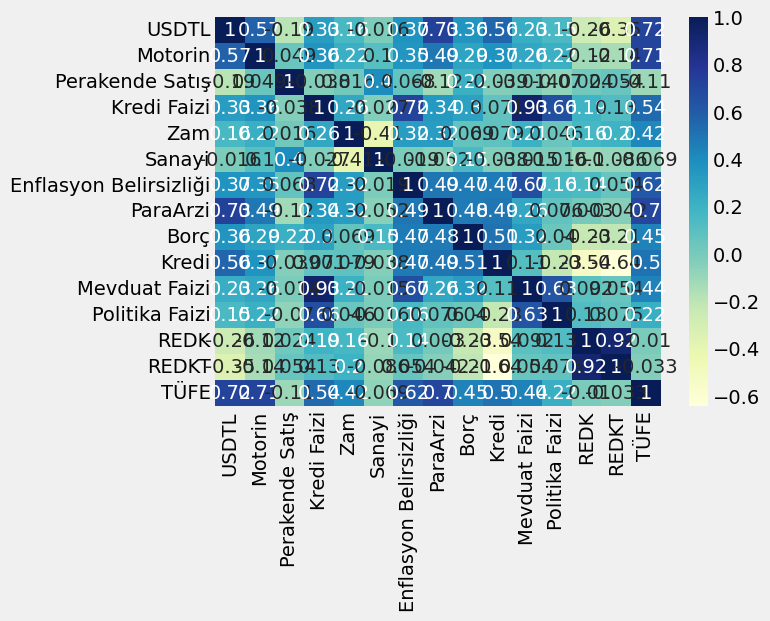

In [32]:
import seaborn as sns
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)

In [396]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'Politika Faizi', 'REDK', 'REDKT','Şok']
best_mse = float("inf")
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]


# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 16):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        model=sm.OLS(y_train,X_train_subset).fit()
        
        
        # Modeli kullanarak tahmin yapın
        y_pred = model.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT']
En iyi MSE değeri: 0.8299928714851995


In [408]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT','Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
model=sm.OLS(y_train,X_train).fit()

        

rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [374]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'Politika Faizi', 'REDK', 'REDKT','Şok']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 16):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        reg = linear_model.BayesianRidge()
        reg.fit(X_train_subset, y_train)
        
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT', 'Şok']
En iyi MSE değeri: 0.8499583053321083


In [409]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT','Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [376]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'Politika Faizi', 'REDK', 'REDKT','Şok']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 16):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        reg = linear_model.Lasso(alpha=0.1)
        reg.fit(X_train_subset,y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDKT', 'Şok']
En iyi MSE değeri: 0.9688421527975936


In [410]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDKT', 'Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [411]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDKT','Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [371]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'Politika Faizi', 'REDK', 'REDKT','Şok']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 16):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        reg = linear_model.Lars(random_state=0)
        reg.fit(X_train_subset,y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = reg.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT', 'Şok']
En iyi MSE değeri: 0.7628862505339186


In [419]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT', 'Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y=data["TÜFE"]
y_train=y[:-9]
y_test=y[-9:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [414]:
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Kredi', 'Mevduat Faizi','REDK','REDKT']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
model = MLPRegressor(random_state=1, max_iter=500000)
model.fit(X_train, y_train)
        



tahminler["MLP Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["MLP Regression"])))


In [377]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'Politika Faizi', 'REDK', 'REDKT','Şok']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 10):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        kernel = DotProduct() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X_train_subset, y_train) 
        
        # Modeli kullanarak tahmin yapın
        y_pred = gpr.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT', 'Şok']
En iyi MSE değeri: 0.8088610096892124


In [415]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT', 'Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
  random_state=0).fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [378]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
best_mse = float("inf")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'Politika Faizi', 'REDK', 'REDKT','Şok']
# En iyi özellik kümesi
best_features = []

# Veriyi eğitim ve test setlerine ayırın
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]

# 2-7 özellikler arasındaki kombinasyonları dene
for r in range(2, 16):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train)
        
        # Modeli kullanarak tahmin yapın
        y_pred = krr.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT']
En iyi MSE değeri: 0.8320029870211403


In [416]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [417]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi','Şok']
X = data[features]
X_train=X.iloc[:-9,:]
X_test=X.iloc[-9:,:]
y_train=y[:-9]
y_test=y[-9:]
model = tf.keras.models.Sequential()
model.add(Dense(units=64,input_dim=X_train.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(16,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X_train,y_train,epochs=100,verbose=0)
        



tahminler["Deep Neural Network"]=model.predict(X_test)
rmse.append((np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Deep Neural Network"]))))

1/1 [==============================] - 0s 69ms/step


In [418]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Lars Regression,0.762886
Gaussian Regression,0.808861
Kernel Regression,0.832003
MLP Regression,0.833050
Linear Regression,0.835043
Bayesian Regression,0.860725
SGD Regressor,0.908065
Lasso Regression,0.968842
Deep Neural Network,1.868480


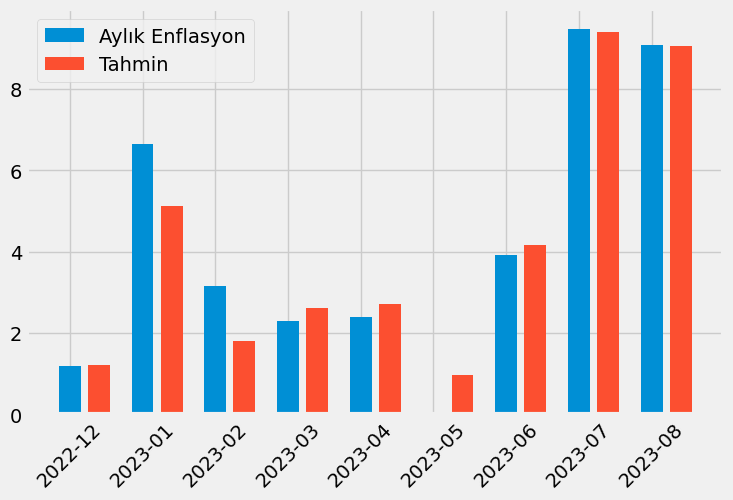

In [389]:
X_axis = np.arange(len(tahminler))
plt.figure(figsize=(8,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Lars Regression"],width=0.3,label="Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.legend()

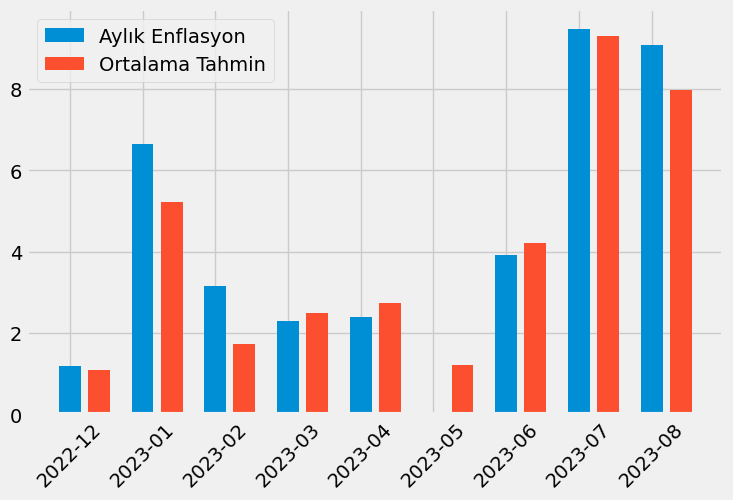

In [390]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
X_axis = np.arange(len(tahminler)) 
plt.figure(figsize=(8,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Ortalama"],width=0.3,label="Ortalama Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.legend()

In [53]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sanayi["Sanayi"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(sanayi['Sanayi'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((0, 0, 0), (1, 0, 1, 12))
En iyi RMSE: 6.280256751249998


In [54]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(sanayi["Sanayi"], order=(0, 0, 0), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Sanayi"]

sanayitahmin=pd.concat([forecast_values],axis=0)
sanayitahmin=sanayitahmin.dropna(axis=0)

row=pd.DataFrame({"Sanayi":sanayi.iloc[210,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
sanayitahmin=pd.concat([row,sanayitahmin],axis=0)
sanayitahmin




,Sanayi
2023-08-31,149.233670
2023-09-30,145.946921
2023-10-31,147.303447
2023-11-30,147.965523
2023-12-31,162.075359
2024-01-31,136.439229
2024-02-29,121.134762
2024-03-31,150.344072
2024-04-30,127.461565
2024-05-31,150.240657


In [55]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(perakende1['Mevsimsellikten ve Takvimden Arındırılmış'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 0, 1), (0, 0, 0, 12))
En iyi RMSE: 14.042042793236474


In [56]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Perakende"]

perakendetahmin=pd.concat([forecast_values],axis=0)
perakendetahmin=perakendetahmin.dropna(axis=0)
perakendetahmin




,Perakende
2023-09-30,175.861239
2023-10-31,175.752870
2023-11-30,175.644568
2023-12-31,175.536333
2024-01-31,175.428164
2024-02-29,175.320062
2024-03-31,175.212026
2024-04-30,175.104057
2024-05-31,174.996155
2024-06-30,174.888319


In [229]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df6["USD/TL"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
usdtahmin=pd.DataFrame(forecast_values)
usdtahmin.columns=["USDTL"]
new_row=pd.DataFrame({"USDTL":df6["USD/TL"].iloc[-5:]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([new_row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.714100
2023-11-30,28.592218
2023-12-31,30.212562
2024-01-31,30.201068
2024-02-29,30.235741
2024-03-31,30.876633


In [233]:
ar_model = AutoReg(df14['Brent'].diff().dropna(axis=0), lags=1)
ar_fit = ar_model.fit()
brenttahmin = ar_fit.predict(start="2023-11-30", end="2025-01-30", dynamic=False)
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]

In [234]:
# Tahminleri orijinal seriyi oluşturmak için kullanın
original_series = [df14['Brent'].iloc[-1]]  # Orijinal serinin son değeri ile başlayın

for i in range(len(brenttahmin)):
    # Tahmin edilen fark değeri ile orijinal seriyi güncelleyin
    original_value = original_series[-1] + brenttahmin['Brent'].iloc[i]
    original_series.append(original_value)

# Orijinal seriyi içeren bir DataFrame oluşturun
original_series = pd.Series(original_series[1:], index=brenttahmin.index)
original_series=pd.DataFrame(original_series)
original_series.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
brenttahmin=pd.concat([row,original_series],axis=0)
# Sonuçları gözlemleyin
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.530000
2023-11-30,89.521975
2023-12-31,89.258927
2024-01-31,89.249952
2024-02-29,89.327630
2024-03-31,89.434860
2024-04-30,89.552170


In [60]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d =  range(0, 3)
q=range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"].iloc[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=12)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(enf_belirsizlik['Enflasyon Belirsizliği'].iloc[-12:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 0, 1), (0, 1, 1, 12))
En iyi RMSE: 0.8402347637373828


In [61]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
import warnings



import pmdarima as pm

from pmdarima.arima import auto_arima



model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(1, 0, 0), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 14 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)

# Tahmin edilen değerleri alın
forecast_values = pd.DataFrame(forecast.predicted_mean)
forecast_values.columns=["Enflasyon Belirsizliği"]

enfbelirsizliktahmin=pd.concat([forecast_values],axis=0)
enfbelirsizliktahmin=enfbelirsizliktahmin.dropna(axis=0)
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-3:,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin




,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,5.475281
2023-12-31,5.382173
2024-01-31,5.290648
2024-02-29,5.200680
2024-03-31,5.112241
2024-04-30,5.025306
2024-05-31,4.939850


In [62]:
from pmdarima.model_selection import train_test_split


model = SARIMAX(pfaiz["Politika Faizi"], order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 14 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
faiztahmin=pd.DataFrame(forecast_values)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,35.000000
2023-11-30,38.236692
2023-12-31,40.965566
2024-01-31,42.745760
2024-02-29,43.994618
2024-03-31,45.189088
2024-04-30,45.796416
2024-05-31,46.110518


In [63]:
model = SARIMAX(money["Para Arzi"].head(212), order=(0, 2, 1), seasonal_order=(0, 2, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:212,0]},index=pd.date_range(start="2023-07-30",end="2023-10-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258
2023-10-31,126.935179
2023-11-30,130.635405
2023-12-31,133.705794
2024-01-31,137.976904
2024-02-29,142.307233
2024-03-31,147.259216
2024-04-30,153.279673


In [64]:
model = SARIMAX(kfaiz.head(212), order=(0, 1, 2), seasonal_order=(0, 1, 2, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:212,0]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.298000
2023-10-31,60.339237
2023-11-30,62.514491
2023-12-31,63.166972
2024-01-31,63.829932
2024-02-29,62.646914
2024-03-31,62.038705
2024-04-30,61.767081
2024-05-31,62.022258


In [65]:
model = SARIMAX(mfaiz.head(212), order=(0, 2, 1), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:212,0]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,42.532383
2023-11-30,43.879057
2023-12-31,46.731941
2024-01-31,49.622952
2024-02-29,50.509025
2024-03-31,51.586057
2024-04-30,53.267782
2024-05-31,54.862620


In [243]:
usdtahmin

,USDTL,brent
2023-07-31,26.470338,80.108095
2023-08-31,26.999127,86.147727
2023-09-30,26.989448,93.722381
2023-10-31,27.714100,90.530000
2023-11-30,28.592218,89.521975
2023-12-31,30.212562,89.258927
2024-01-31,30.201068,89.249952
2024-02-29,30.235741,89.327630
2024-03-31,30.876633,89.434860
2024-04-30,31.123116,89.552170


In [253]:
usdtahmin["brent"]=brenttahmin
usdtahmin=usdtahmin.dropna(axis=0)
degisim=pd.DataFrame((((usdtahmin["USDTL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-08-30",end="2025-02-27",freq="1M"))
degisim.columns=["Değişim"]
degisim=degisim.tail(17)
degisim

,Değişim
2023-09-30,1.087536
2023-10-31,0.991873
2023-11-30,1.020197
2023-12-31,1.053566
2024-01-31,0.999519
2024-02-29,1.002019
2024-03-31,1.022422
2024-04-30,1.009305
2024-05-31,1.022358
2024-06-30,1.055196


In [254]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=39.18
for i in range(1,16):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[247,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.861577
2023-11-30,39.646480
2023-12-31,41.770179
2024-01-31,41.750090
2024-02-29,41.834401
2024-03-31,42.772427
2024-04-30,43.170423
2024-05-31,44.135647


In [68]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1, 2, 0), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
perakendetahmin=pd.DataFrame(forecast_values)
perakendetahmin.columns=["Perakende Satış"]
new_row=pd.DataFrame({"Perakende Satış":perakende1.iloc[163,2]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
perakendetahmin=pd.concat([new_row,perakendetahmin],axis=0)
perakendetahmin

,Perakende Satış
2023-08-31,176.819213
2023-09-30,172.889609
2023-10-31,167.361304
2023-11-30,162.372977
2023-12-31,157.202266
2024-01-31,152.093158
2024-02-29,146.963242
2024-03-31,141.840355
2024-04-30,136.715094
2024-05-31,131.590634


In [69]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [70]:
model = SARIMAX(data["Kredi"], order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":0.78},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-08-31,0.780000
2023-09-30,0.914480
2023-10-31,1.646478
2023-11-30,2.650646
2023-12-31,2.500304
2024-01-31,1.023724
2024-02-29,0.831675
2024-03-31,2.707252
2024-04-30,3.011096
2024-05-31,2.220475


In [71]:
model = SARIMAX(data["Borç"], order=(1, 2, 1), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":4.38},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-08-31,4.380000
2023-09-30,6.239717
2023-10-31,4.390547
2023-11-30,5.572126
2023-12-31,4.968610
2024-01-31,5.311808
2024-02-29,5.264620
2024-03-31,5.254397
2024-04-30,5.884392
2024-05-31,5.349260


In [188]:
from pmdarima.arima import auto_arima

results = auto_arima(df6["USD/TL"], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=191.842, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=285.979, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=210.848, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=189.945, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=244.095, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=187.198, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=186.751, Time=0.21 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=187.302, Time=0.59 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=189.070, Time=2.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=253.421, Time=0.43 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=188.543, Time=0.28 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=188.566, Time=0.24 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=190.468, Time=0.60 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=185.486, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12] intercep

In [257]:
model = SARIMAX(df6["USD/TL"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
usdtahmin=pd.DataFrame(forecast_values)
usdtahmin.columns=["USDTL"]
new_row=pd.DataFrame({"USDTL":df6["USD/TL"].iloc[-5:]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([new_row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.714100
2023-11-30,28.592218
2023-12-31,30.212562
2024-01-31,30.201068
2024-02-29,30.235741
2024-03-31,30.876633


In [185]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# Veriyi yükleyin veya veriyi oluşturun
# Örneğin, 'veri.csv' adlı bir CSV dosyasından veriyi yükleyin


# Modelin parametre kombinasyonlarını tanımlayın
p = d =  range(0, 3)
q=range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_rmse = float("inf")
best_params = None

# En iyi modeli seçin
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df6["USD/TL"].iloc[:-6],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            # Tahminleri yapın
            pred = results.get_forecast(steps=6)
            forecasted = pred.predicted_mean

            # RMSE hesaplayın
            rmse = sqrt(mean_squared_error(df6["USD/TL"].iloc[-6:], forecasted))

            # En iyi RMSE'yi ve parametreleri güncelleyin
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, param_seasonal)

        except:
            continue

print("En iyi parametreler:", best_params)
print("En iyi RMSE:", best_rmse)


En iyi parametreler: ((1, 2, 0), (0, 2, 0, 12))
En iyi RMSE: 0.9496402278555384


In [165]:
model = SARIMAX(redk["REDK"], order=(1, 2, 1), seasonal_order=(2, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redktahmin=pd.DataFrame(forecast_values)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[84.81,88.29]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,84.810000
2023-09-30,88.290000
2023-10-31,89.346505
2023-11-30,89.536726
2023-12-31,88.234372
2024-01-31,90.288010
2024-02-29,92.663012
2024-03-31,92.359531
2024-04-30,92.236155
2024-05-31,92.588849


In [167]:
model = SARIMAX(redkt["REDKT"], order=(2, 0, 0), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redkttahmin=pd.DataFrame(forecast_values)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.42,55.52]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.420000
2023-09-30,55.520000
2023-10-31,56.927541
2023-11-30,57.390913
2023-12-31,56.943066
2024-01-31,57.435361
2024-02-29,57.988214
2024-03-31,57.701967
2024-04-30,57.734041
2024-05-31,57.202560


In [438]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,redktahmin,redkttahmin],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Kredi"]=kreditahmin["Kredi"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["Borç"]=borctahmin["Borç"]
tahmindf["Politika Faizi"]=faiztahmin





tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','Politika Faizi','REDK','REDKT']]



tahmindf.columns=data.columns[:14]
tahmindf=tahmindf.dropna(axis=0)
tahmindf


,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Politika Faizi,REDK,REDKT
2023-09-30,5.071342,4.843457,-2.222385,56.298000,0.0,-2.202417,7.300000,5.195375,6.239717,0.914480,41.656000,31.000000,4.103290,5.913773
2023-10-31,1.545835,-0.812718,-3.197593,60.339237,0.0,0.929465,5.570000,2.782256,4.390547,1.646478,42.532383,35.000000,1.196630,2.535196
2023-11-30,1.949864,2.019739,-2.980574,62.514491,0.0,0.449464,5.475281,3.683816,5.572126,2.650646,43.879057,38.236692,0.212903,0.813968
2023-12-31,3.869482,5.356591,-3.184465,63.166972,0.0,9.535894,5.382173,2.915052,4.968610,2.500304,46.731941,40.965566,-1.454547,-0.780344
2024-01-31,2.874480,-0.048096,-3.250022,63.829932,35.0,-15.817414,5.290648,2.350350,5.311808,1.023724,49.622952,42.745760,2.327481,0.864540
2024-02-29,1.846534,0.201942,-3.372877,62.646914,0.0,-11.217057,5.200680,3.194409,5.264620,0.831675,50.509025,43.994618,2.630473,0.962565
2024-03-31,0.732571,2.242237,-3.485829,62.038705,0.0,24.113070,5.112241,3.138445,5.254397,2.707252,51.586057,45.189088,-0.327511,-0.493630
2024-04-30,1.009762,0.930497,-3.613401,61.767081,0.0,-15.220092,5.025306,3.479783,5.884392,3.011096,53.267782,45.796416,-0.133582,0.055585
2024-05-31,1.670067,2.235845,-3.748276,62.022258,0.0,17.871342,4.939850,4.088340,5.349260,2.220475,54.862620,46.110518,0.382381,-0.920568
2024-06-30,2.780990,5.519619,-3.894449,61.799088,0.0,-10.079126,4.855847,1.422587,5.348660,3.164212,57.836367,46.767169,-0.706391,-1.150108


In [455]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Kredi', 'Mevduat Faizi','REDK','REDKT']
X = data[features]
model = MLPRegressor(random_state=1, max_iter=500000)
model.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin = []
mlptahmin=model.predict(tahmindf[features])
mlptahmin=1+(mlptahmin/100)
for elem in mlptahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin.append(tüfe)
tüfetahmin=pd.DataFrame(tüfetahmin)
tüfetahmin=tüfetahmin.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin.columns=["MLP Regression"]
tüfetahmin

,MLP Regression
2023-09-30,1694.976094
2023-10-31,1769.865464
2023-11-30,1852.412051
2023-12-31,1938.537925
2024-01-31,1988.619083
2024-02-29,2032.198666
2024-03-31,2109.555216
2024-04-30,2195.385255
2024-05-31,2261.244976
2024-06-30,2360.243771


In [456]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDKT']


X = data[features]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin1 = []
sgdtahmin=reg.predict(tahmindf[features])
sgdtahmin=1+(sgdtahmin/100)
for elem in sgdtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin1.append(tüfe)
tüfetahmin1=pd.DataFrame(tüfetahmin1)
tüfetahmin1=tüfetahmin1.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin1.columns=["SGD Regressor"]

tüfetahmin1

,SGD Regressor
2023-09-30,1683.054515
2023-10-31,1740.898308
2023-11-30,1813.517753
2023-12-31,1897.923464
2024-01-31,1994.115702
2024-02-29,2061.309926
2024-03-31,2158.573912
2024-04-30,2250.832589
2024-05-31,2350.834718
2024-06-30,2467.075427


In [457]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT']


X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin2 = []
bayesiantahmin=reg.predict(tahmindf[features])
bayesiantahmin=1+(bayesiantahmin/100)
for elem in bayesiantahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin2.append(tüfe)
tüfetahmin2=pd.DataFrame(tüfetahmin2)
tüfetahmin2=tüfetahmin2.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin2.columns=["Bayesian Regression"]

tüfetahmin2




,Bayesian Regression
2023-09-30,1685.661117
2023-10-31,1747.462811
2023-11-30,1824.280224
2023-12-31,1914.004310
2024-01-31,2012.029641
2024-02-29,2080.512525
2024-03-31,2183.641373
2024-04-30,2282.529172
2024-05-31,2387.205184
2024-06-30,2510.564944


In [458]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT']

X = data[features]
model=sm.OLS(y,X).fit()


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin3 = []    
lineartahmin=model.predict(tahmindf[features])
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin3.append(tüfe)
tüfetahmin3=pd.DataFrame(tüfetahmin3)
tüfetahmin3=tüfetahmin3.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin3.columns=["Linear Regression"]

tüfetahmin3

,Linear Regression
2023-09-30,1684.194485
2023-10-31,1724.622008
2023-11-30,1771.306996
2023-12-31,1830.980118
2024-01-31,1889.941800
2024-02-29,1918.941700
2024-03-31,1962.742125
2024-04-30,2004.973130
2024-05-31,2046.797992
2024-06-30,2105.602725


In [459]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDKT']

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin5 = []
lassotahmin=reg.predict(tahmindf[features])
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin5.append(tüfe)
tüfetahmin5=pd.DataFrame(tüfetahmin5)
tüfetahmin5=tüfetahmin5.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin5.columns=["Lasso Regression"]

tüfetahmin5

,Lasso Regression
2023-09-30,1681.421906
2023-10-31,1738.348409
2023-11-30,1810.408913
2023-12-31,1893.929751
2024-01-31,1989.654681
2024-02-29,2055.863346
2024-03-31,2152.323355
2024-04-30,2244.713817
2024-05-31,2343.734782
2024-06-30,2459.956228


In [460]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense

features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi','REDK','REDKT']

X = data[features]
model = tf.keras.models.Sequential()
model.add(Dense(units=32,input_dim=X.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X,y,epochs=100,verbose=0)


 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin4 =[]
dnntahmin=model.predict(tahmindf[features])
dnntahmin=1+(dnntahmin/100)
tüfe = [1614]

tufe_degerleri = tüfe
for oran in dnntahmin:
    tufe_degerleri.append(tufe_degerleri[-1] * oran)

# DataFrame oluştur
tüfetahmin4 = pd.DataFrame({'DNN': tufe_degerleri},index=pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))

tüfetahmin4["DNN"]=tüfetahmin4["DNN"].astype(float)
tüfetahmin4=tüfetahmin4.tail(16)
tüfetahmin4

1/1 [==============================] - 0s 68ms/step


,DNN
2023-09-30,1701.361694
2023-10-31,1780.316406
2023-11-30,1874.541992
2023-12-31,1976.995239
2024-01-31,2093.014404
2024-02-29,2197.372559
2024-03-31,2305.154297
2024-04-30,2421.664307
2024-05-31,2544.571289
2024-06-30,2673.501953


In [461]:

features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'Politika Faizi', 'REDK', 'REDKT']
X = data[features]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin6 = []
larstahmin=reg.predict(tahmindf[features])
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin6.append(tüfe)
tüfetahmin6=pd.DataFrame(tüfetahmin6)
tüfetahmin6=tüfetahmin6.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin6.columns=["Lars Regression"]

tüfetahmin6

,Lars Regression
2023-09-30,1697.994106
2023-10-31,1760.984860
2023-11-30,1835.953907
2023-12-31,1927.348847
2024-01-31,2019.230344
2024-02-29,2081.667918
2024-03-31,2171.086102
2024-04-30,2262.013569
2024-05-31,2352.670786
2024-06-30,2467.420306


In [462]:
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Bayesian Regression"]=tüfetahmin2["Bayesian Regression"]
tüfetahmin["Linear Regression"]=tüfetahmin3["Linear Regression"]
#tüfetahmin["DNN"]=tüfetahmin4["DNN"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,Lasso Regression,Lars Regression
2023-09-30,1694.976094,1683.054515,1685.661117,1684.194485,1681.421906,1697.994106
2023-10-31,1769.865464,1740.898308,1747.462811,1724.622008,1738.348409,1760.984860
2023-11-30,1852.412051,1813.517753,1824.280224,1771.306996,1810.408913,1835.953907
2023-12-31,1938.537925,1897.923464,1914.004310,1830.980118,1893.929751,1927.348847
2024-01-31,1988.619083,1994.115702,2012.029641,1889.941800,1989.654681,2019.230344
2024-02-29,2032.198666,2061.309926,2080.512525,1918.941700,2055.863346,2081.667918
2024-03-31,2109.555216,2158.573912,2183.641373,1962.742125,2152.323355,2171.086102
2024-04-30,2195.385255,2250.832589,2282.529172,2004.973130,2244.713817,2262.013569
2024-05-31,2261.244976,2350.834718,2387.205184,2046.797992,2343.734782,2352.670786
2024-06-30,2360.243771,2467.075427,2510.564944,2105.602725,2459.956228,2467.420306


In [464]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.iloc[1:,2]],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=[tüfetahmin.columns[2]]

dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[3]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[4]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[5]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas3,dfas4,dfas5,dfas6],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








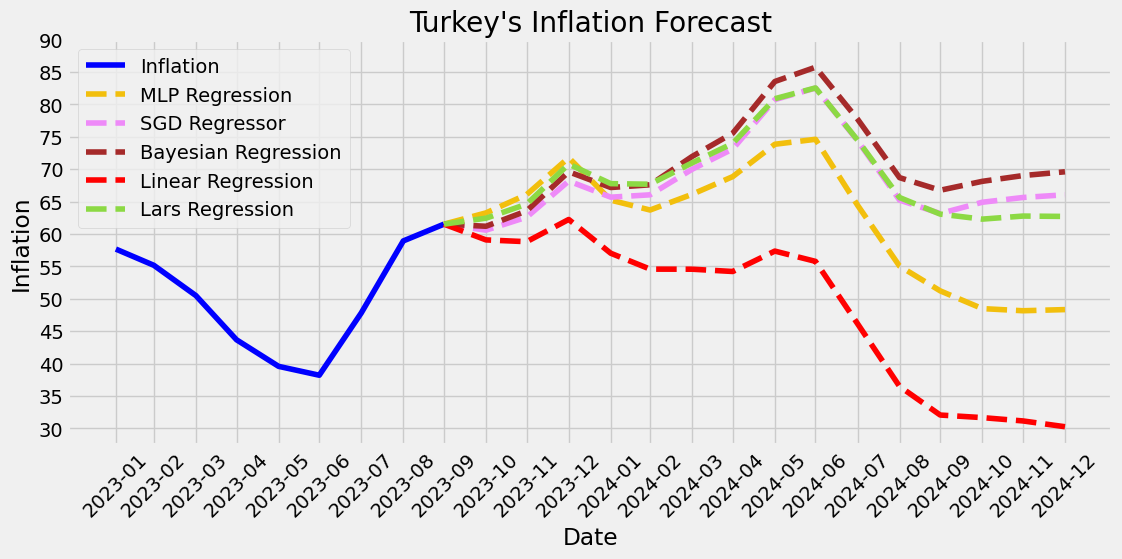

In [465]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:200,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[199:,0],'--',label=dfas.columns[0], color='#F2BF0D')
plt.plot(dfas.iloc[199:,1],'--',label=dfas.columns[1], color='#EE8AF8')
plt.plot(dfas.iloc[199:,2],'--',label=dfas.columns[2], color='brown')
plt.plot(dfas.iloc[199:,3],'--',label=dfas.columns[3], color='red')
plt.plot(dfas.iloc[199:,5],'--',label=dfas.columns[5], color='#8CD944')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:].index, dfas.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [30]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [466]:
eylül_tahmin=((tüfetahmin.iloc[0,:]/1614)-1)*100
eylül_tahmin

MLP Regression         5.017106
SGD Regressor          4.278471
Bayesian Regression    4.439970
Linear Regression      4.349101
Lasso Regression       4.177318
Lars Regression        5.204096
Name: 2023-09-30 00:00:00, dtype: float64

In [467]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
row=pd.DataFrame({eylül_tahmin.index[0]:eylül_tahmin[0],eylül_tahmin.index[1]:eylül_tahmin[1],eylül_tahmin.index[2]:eylül_tahmin[2],eylül_tahmin.index[3]:eylül_tahmin[3],eylül_tahmin.index[4]:eylül_tahmin[4],eylül_tahmin.index[5]:eylül_tahmin[5]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,Lasso Regression,Lars Regression,Ortalama,Medyan
2023-09-30,5.017106,4.278471,4.439970,4.349101,4.177318,5.204096,4.577677,4.439970
2023-10-31,4.418314,3.436834,3.666318,2.400407,3.385617,3.709716,3.502868,3.502868
2023-11-30,4.664004,4.171378,4.395940,2.706969,4.145343,4.257223,4.056809,4.171378
2023-12-31,4.649391,4.654253,4.918328,3.368875,4.613369,4.978063,4.530380,4.649391
2024-01-31,2.583450,5.068289,5.121479,3.220225,5.054302,4.767248,4.302499,4.767248
2024-02-29,2.191450,3.369625,3.403672,1.534434,3.327646,3.092147,2.819829,3.092147
2024-03-31,3.806545,4.718552,4.956896,2.282530,4.691947,4.295507,4.125329,4.295507
2024-04-30,4.068632,4.274057,4.528573,2.151633,4.292592,4.188110,3.917266,4.188110
2024-05-31,2.999916,4.442895,4.585966,2.086056,4.411296,4.007810,3.755657,4.007810
2024-06-30,4.378066,4.944657,5.167539,2.873011,4.958814,4.877415,4.533250,4.877415


In [468]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=dfas.mean(axis=1)
yıllıktahmin["Medyan"]=dfas.median(axis=1)
yıllıktahmin.tail(15)

,MLP Regression,SGD Regressor,Bayesian Regression,Linear Regression,Lasso Regression,Lars Regression,Ortalama,Medyan
2023-10-31,63.271722,60.599475,61.205056,59.097971,60.364244,62.452478,61.165158,60.902266
2023-11-30,66.096879,62.609414,63.574433,58.824579,62.330660,64.621156,63.009520,63.091924
2023-12-31,71.787667,68.188530,69.613568,62.256203,67.834618,70.796123,68.412785,68.901049
2024-01-31,65.239064,65.695791,67.184302,57.039735,65.325114,67.782626,64.711105,65.510452
2024-02-29,63.711396,66.056562,67.603500,54.587555,65.617793,67.696577,64.212230,65.837178
2024-03-31,66.139415,69.999914,71.974119,54.577053,69.507648,70.985320,67.197245,69.753781
2024-04-30,68.870593,73.135641,75.573765,54.223957,72.664981,73.995690,69.744104,72.900311
2024-05-31,73.861677,80.750017,83.546454,57.373366,80.204120,80.891188,76.104470,80.477068
2024-06-30,74.627200,82.531347,85.749003,55.787090,82.004619,82.556863,77.209353,82.267983
2024-07-31,64.462850,74.425627,77.748063,46.172547,73.893616,74.515560,68.536377,74.159621


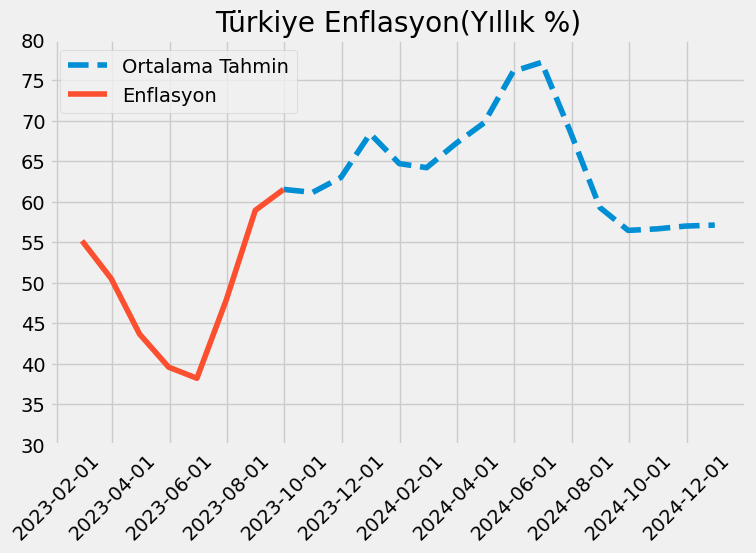

In [469]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
plt.plot(yıllıktahmin["Ortalama"].tail(16),'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[-23:-15],label="Enflasyon")
plt.xticks(yıllıktahmin.tail(23).index.strftime("%Y-%m")[::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend()
plt.show()